In [1]:
import sklearn

In [2]:
print(sklearn.__path__)

['/home/brightLLer/anaconda3/envs/speech/lib/python3.5/site-packages/sklearn']


In [3]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.datasets import load_breast_cancer
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler

In [4]:
cancer_data = load_breast_cancer()

In [5]:
print(cancer_data.data.shape, cancer_data.target.shape)

(569, 30) (569,)


In [6]:
X_train, X_test, y_train, y_test = train_test_split(cancer_data.data, cancer_data.target, random_state=0)

In [8]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(426, 30) (426,)
(143, 30) (143,)


In [9]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [10]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100], 'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}

In [11]:
grid = GridSearchCV(SVC(), param_grid, scoring='accuracy', cv=5, n_jobs=-1)
grid.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100], 'gamma': [0.001, 0.01, 0.1, 1, 10, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [12]:
print("Best cv scores: {}".format(grid.best_score_))
print("Best test set score: {}".format(grid.score(X_test_scaled, y_test)))
print("Best params: {}".format(grid.best_params_))

Best cv scores: 0.9812206572769953
Best test set score: 0.972027972027972
Best params: {'C': 1, 'gamma': 1}


+ 上述做法存在一个比较大的问题，那就是在交叉验证前我们已经用scaler分别对X_train和X_test做好了处理，这样做的坏处是：scaler.fit用在了整个训练集X_train，而我们在执行cv的时候会让X_train = train_part + val_part，这会在训练train_part的时候过早地引入了val_part的信息，因此模型的整体效果会偏好。<br>
<img src='img/cv_incorrect.png' />

+ 为了解决上述问题，我们可以引入pipeline + gridsearch的处理方法来解决问题。

In [13]:
from sklearn.pipeline import Pipeline

In [14]:
pipe = Pipeline([('scaler', MinMaxScaler()), ('svm', SVC())])

+ pipeline和gridsearch组合挑选参数是，参数的格式为每一步的模型的名字 + \__\(双下划线) + 模型的参数名，比如我们要选择第二步的svm的参数，svm又有C和gamma两个参数，因此总的参数名表示为svm_C, svm_gamma

In [20]:
param_grid = {'svm__C': [0.001, 0.01, 0.1, 1, 10, 100], 'svm__gamma': [0.001, 0.01, 0.1, 1, 10, 100]}

In [22]:
# 注意这里是pipe不是原来的SVC
grid = GridSearchCV(pipe, param_grid, scoring='accuracy', cv=5, n_jobs=-1)
# 注意这里是X_train而不再是X_train_scaled
grid.fit(X_train, y_train)
print("Best cv scores: {:.2f}".format(grid.best_score_))
# 注意这里是X_test而不再是X_test_scaled
print("Best test set score: {:.2f}".format(grid.score(X_test, y_test)))
print("Best params: {}".format(grid.best_params_))

Best cv scores: 0.98
Best test set score: 0.97
Best params: {'svm__C': 1, 'svm__gamma': 1}


+ pipeline和gridsearch组合下，X_train不再预先经过scale，而是在执行cv分割train_part和val_part的同时使用pipeline分别对它们scale，这样就不会让训练集预先看到验证集的信息，如下图所示：<br>
<img src='img/cv_correct.png'>

+ make_pipeline是一个简化版的pipeline，它不需要指定每一步的名字，因为名字被默认为每一步的estimator或者transformer的类名的小写

In [23]:
from sklearn.pipeline import make_pipeline
pipe_long = Pipeline([("scaler", MinMaxScaler()), ("svm", SVC(C=100))])
pipe_short = make_pipeline(MinMaxScaler(), SVC(C=100))

In [25]:
print(pipe_long.steps)
print('\n')
print(pipe_short.steps)

[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('svm', SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))]


[('minmaxscaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('svc', SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))]


+ pipeline在与gridsearch使用时还可以综合每一步的参数进行搜索，看下面的一个例子

In [27]:
from sklearn.datasets import load_boston
boston = load_boston()
X_train, X_test, y_train, y_test = train_test_split(boston.data, boston.target, random_state=0)

In [28]:
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import Ridge
pipe = make_pipeline(StandardScaler(), PolynomialFeatures(), Ridge())

In [29]:
param_grid = {'polynomialfeatures__degree': [1, 2, 3], 'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100]}

In [30]:
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5, n_jobs=-1)
grid.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('polynomialfeatures', PolynomialFeatures(degree=2, include_bias=True, interaction_only=False)), ('ridge', Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100], 'polynomialfeatures__degree': [1, 2, 3]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [31]:
import matplotlib.pyplot as plt
%matplotlib inline

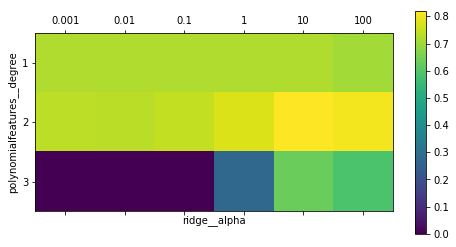

In [32]:
plt.matshow(grid.cv_results_['mean_test_score'].reshape(3, -1), vmin=0, cmap="viridis")
plt.xlabel("ridge__alpha")
plt.ylabel("polynomialfeatures__degree")
plt.xticks(range(len(param_grid['ridge__alpha'])), param_grid['ridge__alpha'])
plt.yticks(range(len(param_grid['polynomialfeatures__degree'])),
param_grid['polynomialfeatures__degree'])
plt.colorbar()
# 可以看到偏黄色部分的验证集评分均是比较